# Uncertainty analysis with presamples

Notebook on uncertainty analysis of site-dependent CFs using presamples, and regionalized CFs.

# Setup

In [1]:
%matplotlib inline

In [2]:
import bw2regional as bwr
import brightway2 as bw
import presamples
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

In [3]:
bw.projects.set_current('LC IMPACT case study')

# Getting a CDF for global land use CFs

Use the consensus land-use cover map from [EarthEnv](https://www.earthenv.org/landcover) as weights for the weighted average:

<img src="images/land_use_agriculture.png">

These values are normalized from 0 to 1, i.e. they are already densities (intensity per unit area), so we can use them directly.

We have this data uploaded to the pandarus remote already, so we don't need to download it locally. We can just use the hash value.

In [3]:
bwr.geocollections["agriculture"] = {
    'band': 1,
    'kind': 'raster',
    'sha256': 'baf0767cd8f589c66738072bc860ecc85a52dd1e035c176cbee216a512fdfb6e'
}

In [5]:
try:
    bwr.remote.calculate_rasterstats('ecoregions', 'agriculture')
except AlreadyExists:
    pass

Calculation job submitted.


In [7]:
bwr.remote.rasterstats_as_xt('ecoregions', 'agriculture', 'ecoregions-agriculture')

Brightway2 ExtensionTable: ecoregions-agriculture

In [34]:
bwr.ExtensionTable('ecoregions-agriculture').load()

[(23.075446724023827, ('ecoregions', 'AA0113')),
 (2.510703363914373, ('ecoregions', 'OC0103')),
 (25.750523497760224, ('ecoregions', 'PA0510')),
 (1.9328358208955223, ('ecoregions', 'AT0703')),
 (10.358433734939759, ('ecoregions', 'NT0216')),
 (26.454689577846732, ('ecoregions', 'PA1020')),
 (0.5691944832670912, ('ecoregions', 'NA0609')),
 (43.94561087735519, ('ecoregions', 'NT0801')),
 (5.084875558391832, ('ecoregions', 'OC0108')),
 (40.231609654059866, ('ecoregions', 'NT0704')),
 (12.87445731954899, ('ecoregions', 'PA0502')),
 (5.473684210526316, ('ecoregions', 'NT0116')),
 (75.35278920223023, ('ecoregions', 'PA0809')),
 (4.99359394658964, ('ecoregions', 'AT0110')),
 (56.62802895768009, ('ecoregions', 'PA0405')),
 (19.432266145967652, ('ecoregions', 'NT0904')),
 (49.66860356676566, ('ecoregions', 'PA0904')),
 (2.7640621202048807, ('ecoregions', 'AT1320')),
 (5.909165155521103, ('ecoregions', 'AT1322')),
 (92.77077712532402, ('ecoregions', 'IM0116')),
 (29.619678442028984, ('ecoregio

In [4]:
weights = {k: v for v, k in bwr.ExtensionTable('ecoregions-agriculture').load()}

To get the CDF for the CF distribution, we need the areal intensity per ecoregion, which we have from the raster, times the area of each ecoregion. We could calculate these areas ourselves, but we have them already from the areal intersections.

In [5]:
import collections

areas = collections.defaultdict(int)

for ecoregion, _, area in bwr.Intersection(('ecoregions', 'world-topo-ecoregions')).load():
    areas[ecoregion] += area
    
areas

defaultdict(int,
            {('ecoregions', 'AA0101'): 1811488364.517954,
             ('ecoregions', 'AA0102'): 6809669030.433289,
             ('ecoregions', 'AA0103'): 2703091057.4212813,
             ('ecoregions', 'AA0104'): 8544525361.908371,
             ('ecoregions', 'AA0105'): 172354633222.358,
             ('ecoregions', 'AA0106'): 25653724403.900066,
             ('ecoregions', 'AA0107'): 16508356305.656567,
             ('ecoregions', 'AA0108'): 2293800043.152262,
             ('ecoregions', 'AA0109'): 9539528.39128412,
             ('ecoregions', 'AA0110'): 1367121945.3953936,
             ('ecoregions', 'AA0111'): 32803184183.888794,
             ('ecoregions', 'AA0112'): 12155946364.392492,
             ('ecoregions', 'AA0113'): 14397529509.630768,
             ('ecoregions', 'AA0114'): 36887110.47483581,
             ('ecoregions', 'AA0115'): 135318501818.71887,
             ('ecoregions', 'AA0116'): 23309574820.79938,
             ('ecoregions', 'AA0117'): 3246268557

In [6]:
weighted_area = {k: v * weights.get(k, 0) for k, v in areas.items()}
total_weighted_area = sum(weighted_area.values())

Now we need the CFs themselves. All agricultural occupation gets the same CF, for better or worse, in LC-IMPACT. We will use the key 'Occupation, permanent crop, non-irrigated, intensive' (the land use used for sugarcane in Brazil) for to retrieve the regionalized CFs.

In [7]:
land_use_key = ('biosphere3', 'e063ee9c-9850-42b5-b01e-4cc9b5ad7152')

In [8]:
cf_mapping = {location: value 
       for key, value, location
       in bw.Method(('LC-IMPACT', 'Land Use', 'Occupation', 'Marginal', 'Certain')).load()
       if key == land_use_key}

cf_mapping

{('ecoregions', 'AA0101'): 6.25e-12,
 ('ecoregions', 'AA0102'): 2.99e-12,
 ('ecoregions', 'AA0103'): 4.72e-12,
 ('ecoregions', 'AA0104'): 2.44e-12,
 ('ecoregions', 'AA0105'): 2.22e-12,
 ('ecoregions', 'AA0106'): 1.95e-12,
 ('ecoregions', 'AA0107'): 2.44e-12,
 ('ecoregions', 'AA0108'): 2.25e-12,
 ('ecoregions', 'AA0109'): 0.0,
 ('ecoregions', 'AA0110'): 1.43e-11,
 ('ecoregions', 'AA0111'): 3.05e-12,
 ('ecoregions', 'AA0112'): 3.45e-12,
 ('ecoregions', 'AA0113'): 1.25e-11,
 ('ecoregions', 'AA0114'): 0.0,
 ('ecoregions', 'AA0115'): 1.64e-12,
 ('ecoregions', 'AA0116'): 2.31e-12,
 ('ecoregions', 'AA0117'): 3.33e-12,
 ('ecoregions', 'AA0118'): 2.55e-12,
 ('ecoregions', 'AA0119'): 5.63e-12,
 ('ecoregions', 'AA0120'): 2.42e-12,
 ('ecoregions', 'AA0121'): 9.29e-13,
 ('ecoregions', 'AA0122'): 1.12e-12,
 ('ecoregions', 'AA0123'): 1.32e-12,
 ('ecoregions', 'AA0124'): 1.97e-12,
 ('ecoregions', 'AA0125'): 2.46e-12,
 ('ecoregions', 'AA0126'): 3.48e-12,
 ('ecoregions', 'AA0127'): 2.64e-12,
 ('ecoregio

In [9]:
EXCLUSIONS = {('ecoregions', 'Rock and Ice'), 'GLO'}

Calculate our global weighted average. The LC-IMPACT provided value is 6.18e-15.

In [10]:
sum(v * cf_mapping[k] for k, v in weighted_area.items() if k not in EXCLUSIONS) / total_weighted_area

3.395060941914711e-13

## Graph our weighted CDF and create sampling function

In [19]:
cfs_reverse = [(v, k) for k, v in cf_mapping.items() if k not in EXCLUSIONS]
cfs_reverse.sort()
xs = np.array([line[0] for line in cfs_reverse])
ys = np.cumsum(np.array([weighted_area.get(key, 0) for _, key in cfs_reverse])) / total_weighted_area
weights = np.array([weighted_area.get(key, 0) for _, key in cfs_reverse]) / total_weighted_area

In [12]:
def get_value_from_weighted_cfs():
    return xs[np.argmax(ys > np.random.random()) + 1]

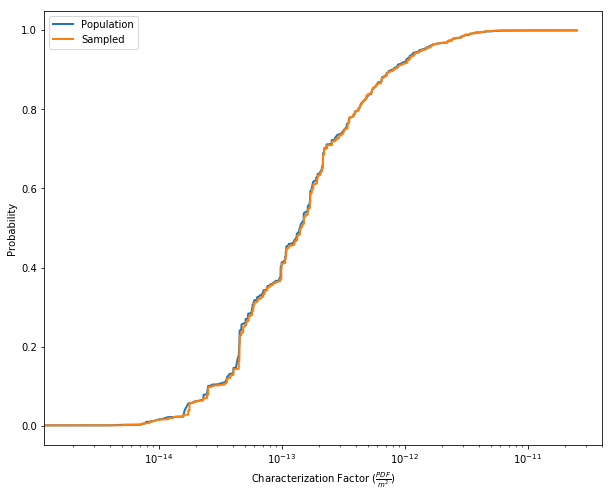

In [13]:
X = 10000
sample_xs = np.array([get_value_from_weighted_cfs() for _ in range(X)])
sample_xs.sort()
sample_ys = np.linspace(0, 1, X)

plt.figure(figsize=(10, 8))
plt.semilogx(xs, ys, lw=2, label="Population")
plt.semilogx(sample_xs, sample_ys, lw=2, label="Sampled")
plt.xlabel(r"Characterization Factor $( \frac{PDF}{m^{2}} )$")
plt.ylabel("Probability")
plt.legend()

# Graph population versus fitted lognormal

In [27]:
from scipy.stats import wasserstein_distance, norm, lognorm
from scipy.optimize import minimize

Initial guess for $\mu$ and $\sigma$ (log-transformed)

In [24]:
points = np.log(xs + 1e-16)

In [31]:
mu, sigma = np.average(points), np.std(points)
mu, sigma

(-29.600146463748068, 2.897130802008518)

Function to calculate distance from observations

In [37]:
def distance_from_data(vector):
    mu, sigma = vector
    ln_sample = norm.ppf(np.linspace(0.01, 0.99, 1000), loc=mu, scale=sigma)
    return wasserstein_distance(points, ln_sample, u_weights=weights)  

Try to fit the normal distribution

In [38]:
result = minimize(distance_from_data, (mu, sigma), bounds=((None, None), (0, None)))
result, guess

(      fun: 0.10213352119907414
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00040317,  0.00012273])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 153
      nit: 9
   status: 0
  success: True
        x: array([-29.60881047,   1.34914861]),
 array([-29.60014646,   2.8971308 ]))

Plot fitted distribution versus actual CFs

In [40]:
fit_mu, fit_sigma = result['x']

-29.608810467836538

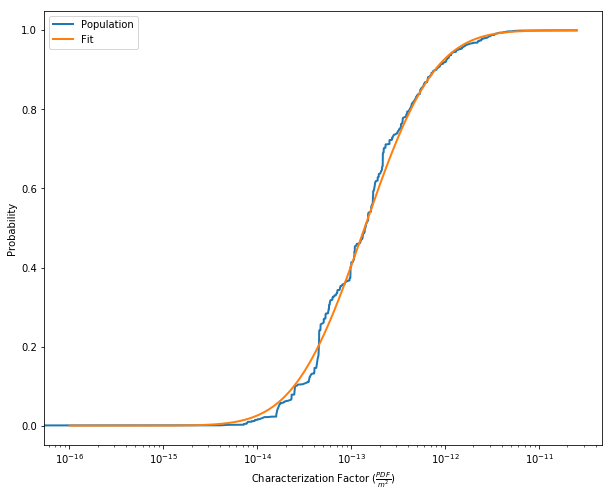

In [41]:
sample_xs = np.linspace(min(points), max(points), 500)
sample_ys = norm.cdf(sample_xs, loc=fit_mu, scale=fit_sigma)

plt.figure(figsize=(10, 8))
plt.semilogx(xs, ys, lw=2, label="Population")
plt.semilogx(np.exp(sample_xs), sample_ys, lw=2, label="Fit")
plt.xlabel(r"Characterization Factor $( \frac{PDF}{m^{2}} )$")
plt.ylabel("Probability")
plt.legend()

# Write presamples arrays

In [93]:
LAND_USE_NAMES = {        
# Not used in ecoinvent 3.5, raises errors for now
    "Occupation, annual crop",
#     "Occupation, annual crop, flooded crop",
    "Occupation, annual crop, greenhouse",
    "Occupation, annual crop, irrigated",
#     "Occupation, annual crop, irrigated, extensive",
    "Occupation, annual crop, irrigated, intensive",
    "Occupation, annual crop, non-irrigated",
    "Occupation, annual crop, non-irrigated, extensive",
    "Occupation, annual crop, non-irrigated, intensive",
    "Occupation, arable land, unspecified use",
#     "Occupation, arable, conservation tillage (obsolete)",
#     "Occupation, arable, conventional tillage (obsolete)",
#     "Occupation, arable, reduced tillage (obsolete)",
#     "Occupation, field margin/hedgerow",
}

LAND_USE_KEYS = [obj.key for obj in bw.Database("biosphere3") if obj['name'] in LAND_USE_NAMES]
len(LAND_USE_KEYS)

8

In [94]:
presamples_array = np.zeros((len(LAND_USE_KEYS), X))

for i in range(len(LAND_USE_KEYS)):
    presamples_array[i, :] = sample_xs

In [95]:
id_, path = presamples.create_presamples_package(
    [(presamples_array, LAND_USE_KEYS, 'cf')], 
    name="Agricultural land use global CF", 
)

In [98]:
path

PosixPath('/Users/cmutel/Library/Application Support/Brightway3/LC-IMPACT-case-study.96518dd8fd4bda5eeaaa02b70dec68e3/presamples/e7c85547df894f42bc97520868aed105')

# Compare site-generic LCIA with and without presamples

In [78]:
fu = {('Fuel comparison', 'sugarcane transport'): 1}

lcia_method = ('LC-IMPACT', 'Land Use', 'Occupation', 'Marginal', 'Certain')

In [90]:
mc = bw.MonteCarloLCA(fu, lcia_method)
next(mc)

1.306389179280635e-15

In [92]:
for key in LAND_USE_KEYS:
    if key not in mc.biosphere_dict:
        print(key, bw.get_activity(key))

('biosphere3', '8222627a-0ca1-4632-894c-94d0e21064a1') 'Occupation, field margin/hedgerow' (square meter-year, None, ('natural resource', 'land'))
('biosphere3', '12c7671c-e4aa-46c6-93c5-b6f9ac1c453b') 'Occupation, annual crop, irrigated, extensive' (square meter-year, None, ('natural resource', 'land'))
('biosphere3', '7956039f-1181-42ab-b03b-ba9992733394') 'Occupation, annual crop, flooded crop' (square meter-year, None, ('natural resource', 'land'))
('biosphere3', 'fdb1b2d0-f537-401e-b845-1d93da512174') 'Occupation, arable, conservation tillage (obsolete)' (square meter, None, ('natural resource', 'land'))
('biosphere3', 'e489cce4-a80f-417d-9ae6-9fc14cc7dd49') 'Occupation, arable, conventional tillage (obsolete)' (square meter, None, ('natural resource', 'land'))
('biosphere3', '81e07a67-28e0-4392-a553-d86e54a9b8a9') 'Occupation, arable, reduced tillage (obsolete)' (square meter, None, ('natural resource', 'land'))


In [84]:
mc_without = bw.MonteCarloLCA(fu, lcia_method)
mc_without_results = np.array([next(mc_without) for _ in range(250)])

In [96]:
mc_with = bw.MonteCarloLCA(fu, lcia_method, presamples=[path])
mc_with_results = np.array([next(mc_with) for _ in range(250)])

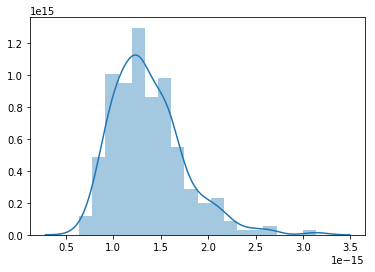

In [85]:
sb.distplot(mc_without_results)

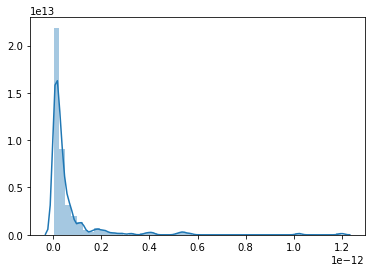

In [97]:
sb.distplot(mc_with_results)